# [Name] - Senior Machine Learning Researcher Task

## Introduction

This task is designed for you to show us your ability in dealing with problems involving probability and probabilistic models. This is a toy example that we found interesting, and we hope you do too. We recommend a maximum time of 4 hours for the task.

## Guidelines

* Our production strategy is in Python 3. It would be great if you could provide a solution in Python, but this isn't a hard requirement and other scientific computing languages are allowed.
* You should provide lots of explanation to allow us to understand your reasoning and approach; this is probably more important than the solution itself. This can be in a jupyter notebook or text form - you should include any intermediate calculations you perform.
* You should provide at least a minimal solution that is all your own implementation - you can also include libraries or specific implementations that you think would offer a better solution than yours, but we're interested in seeing your understanding of how to solve these problems from first principles. Using a normal numerical computation stack is fine - e.g. Numpy and Scipy or equivalents in other languages are acceptable, but try to avoid higher level libraries specialised to the tasks below. 
* Do not worry if you struggle to answer some parts in the suggested time.

## Deliverables

* A solution to the 3 questions below.
* Explanation for each of your solutions, with sufficient detail for us to understand your whole approach.
* A list of any external resources you used to develop your submission.

## Task

You have been tasked with building a simulation for an internal industrial process. As part of this simulation, you have to draw samples for a specific part of the system.

A domain expert has told you that the outcome in question has a probability distribution that has finite support, and is given by:

$p(x) \propto x^{\alpha}$ when $x \in [1,2]$ and 0 otherwise.

Where $\alpha$ parameterises the distribution.

1) Given a uniform sampler (e.g. numpy.random.uniform), write a routine to sample from this distribution. Your routine should correctly generate samples for every value of alpha. Using this routine generate 20 million samples at both $\alpha=1 \ and \ \alpha=-1$ and demonstrate the correctness of your routine. 

b) Is the CDF of the random variable continuous in alpha?

2) The final goal of your simulation is to generate samples of the random variable, y, which is related to the above random variable, x, by the conditional distribution:

$p(y\mid x) \propto (y-0.1)(y+0.1)(y-1.2)(y-x)+0.8 \ $ when $y \in [1,2]$ and 0 otherwise.

and

$p(x) \propto x^{-1}$ when $x \in [1,2]$ and 0 otherwise.

Write a routine to sample approximately 20 million samples from p(y). 

3) If you were given some data, how would you go about fitting the first model, $p(x) \propto x^{\alpha}$, so as to discover the 'best' value for alpha? Your answer should be specific to this particular problem, rather than a general approach. E.g. If you suggest an analytical approach, you should show sufficient detail to show that this is tractable. If you suggest a practical approach you should identify particular algorithms that you would use for each part.

b) Implement your idea from above, using some data generated at alpha=10 to verify it is correct.

---------------------------------
---------------------------------
---------------------------------

## Answers:

---------------------------------
- **time**: (i) 1.5 hours for questions 1 & 2; (ii) 2h for question 2 (mostly reading MCMC - in finance sims are sampled from well-known distributions, mostly Normal and Exponential).
- **resources**: (i) https://arxiv.org/abs/0706.1062 for questions 1 & 2; (ii) old book 'Simulation' (4th edition 2006) by Sheldon M. Ross" 
---------------------------------

### 1) 

#### Normalization
We have that $p(x)$ is proportional to a power of $x$, so let's start finding the proportionality constant $C$ that makes it a distribution, i.e. the non-zero C such that:

$ C \, \int_{x \in [1,2]} x^{\alpha} dx = 1$.

Simple algebra shows that $C = \frac{\alpha + 1}{2^{a+1} - 1}$:

$C^{-1} = \int_1^2 x^\alpha dx = \frac{x^{a+1}}{\alpha+1} \Big]^{2}_{1} = \frac{2^{a+1} - 1}{\alpha + 1}$ and, finally, inverting we get the result above.


Hence: 

$p(x) = \underbrace{\frac{\alpha + 1}{2^{a+1} - 1}}_{C} \, x^{\alpha} \;\;\;\; ,\; \text{for} \; x \in [1,2]$


Since the support of the function is a bounded interval (here $[1,2]$), the probability distribution is also defined for $alpha > -1$; which is not the case for usual power laws that are *unbounded* from above (i.e. with $ x \in [x_{min},\infty)$), indeed a simple integral test shows that for alpha equal to -1 (and hence also, by comparison test, for bigger values) such unbounded power laws cannot be distributions: $\int^{\infty} x^{-1} = \ln(\infty) = \infty$.  

We note, however, that the prob. distribution is not well defined for $\alpha=-1$ - this answer question 1.b) regarding the *non-continuity in alpha* for the CDF. 

In order to sample from every alpha, we find the normalisation constat $C$ for $p(x) \propto x^{-1}$ as done earlier and, for $x \in [1,2]$, and we get the distribution for the two cases:

$  p(x)=\begin{cases}
    \frac{1}{\ln(2)} \, x^{-1} & \text{if $\alpha=-1$}\\
    \frac{\alpha + 1}{2^{a+1} - 1} \, x^{\alpha}, & \text{otherwise}
  \end{cases}
$

#### sampling
To sample from the distribution above, we invert the (closed-form) CDF on a uniform random variable $U$ between $[0,1)$ (*inverse transformation method*): 

since $\underbrace{\int_1^x p(s) ds}_{CDF(x)} = U$, then $x = CDF^{-1}(U)$

- For $\alpha \neq -1$:

    the CDF(x) is: 
    $\frac{\alpha + 1}{2^{a+1} - 1} \, \int_1^x s^{\alpha} ds = \frac{\alpha + 1}{2^{a+1} - 1} \;  \frac{s^{a+1}}{\alpha+1} \Big]^{x}_{1} = \frac{x^{a+1}-1}{2^{a+1} - 1}$

    inverting, we get the random variable for $p(x)$:  $x = [(2^{a+1} - 1) \; U + 1]^{\frac{1}{a+1}}$

    As a sanity check, we can get the two bounds (i) if $U=0$ then $x = 1$ and (ii) if $U \to 1$ then $x \to 2$ and,
    
    hence, for $U \in (0,1)$ any value of $x \in (1,2)$.
    
    
    
- For $\alpha = -1$:

    the CDF(x) is: 
    $\frac{1}{\ln(2)} \, \int_1^x s^{-1}  ds = \frac{\ln(x)}{\ln(2)}$
    
    hence, $x = {\rm e}^{\ln(2) \;U}$



We first generate the 20 million uniform random variables:

In [47]:
import numpy as np
from numpy.random import uniform

no_rnd_samples = int(20e6)  # 20 million

U = uniform(size=no_rnd_samples)

# # for reproducibility:
# from numpy.random import RandomState
# rs = RandomState(101)  # seed in order to reproduce results
# U = rs.uniform(size=no_rnd_samples)

We can now generate the samples for the two values of $\alpha=1$ and $\alpha=-1$:

In [48]:
def sample_px(alpha, no_samples, U_rnd=None):
    import numpy as np    
    # generate uniform if not already passed
    if U_rnd is None: U_rnd = np.random.uniform(size=no_samples)
        
    if alpha == -1:        
        return np.exp(np.log(2) * U_rnd)
    else:
        a_1 = alpha + 1
        return ( (2**a_1 - 1) * U_rnd + 1 )**(1/a_1)
    

# alpha = 1
samples_a1 = sample_px(alpha=1, no_samples=no_rnd_samples, U_rnd=U)  # = np.sqrt((4 - 1) * U + 1) 


# alpha = -1
samples_a_less1 = sample_px(alpha=-1, no_samples=no_rnd_samples, U_rnd=U)  # = np.exp(np.log(2) * U)

print(samples_a1[:5])
print(samples_a_less1[:5])

[1.19990585 1.15030533 1.31422806 1.57608899 1.22877765]
[1.10695099 1.07753454 1.18295768 1.40901357 1.12503106]


let's check if our samples are correct. To keep it simple we compare the normalised histogram of such samples ('empirical') vs. the  probability distribution ('theoretical').

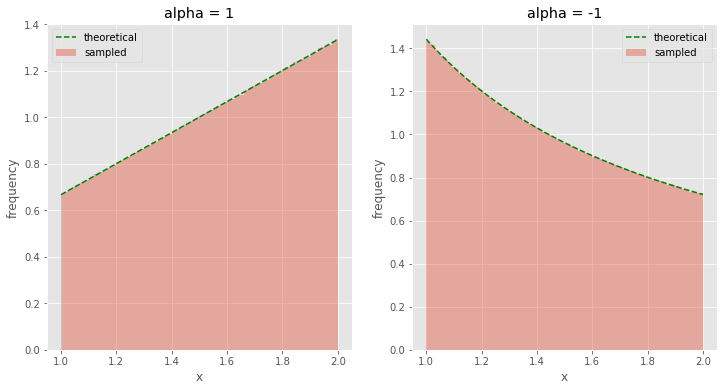

In [49]:
import matplotlib.pyplot as plt
plt.style.use ('ggplot')
import seaborn as sns
% matplotlib inline

def i_my_plot(samples, theo, bin_values, title):
    """ quick & dirty
    """
    no_bins = len(bin_values)-1  # no_bins
    sns.distplot(samples, norm_hist=True, kde=False, bins=no_bins, label="sampled")  # or plt.hist(U, bins =no_bins, label="empirical")
    plt.plot(bin_values, theo,'g--', label="theoretical")
    plt.xlabel("x"); plt.ylabel("frequency")
    plt.title(title)
    plt.legend()

    
no_bins = 100
xx = np.array([1.+i/no_bins for i in range(0,no_bins+1)])

plt.figure(figsize =(12 ,6))

# alpha = 1
p_1 = 2./3. * xx  # p_1 = lambda x: 2/3  x # from p(x) above with alpha=1
plt.subplot (1 ,2 ,1)
i_my_plot(samples_a1, p_1, xx, "alpha = 1")
 
# alpha = -1
p_2 =  1./np.log(2) * xx**(-1)  # p_1 = lambda x: 2/3  x # from p(x) above with alpha=1    
plt.subplot (1 ,2 ,2)
i_my_plot(samples_a_less1, p_2, xx, "alpha = -1")

The routine, looking at the two graphs above, appears correct.

### 2) 

Our task is to sample $p(y)$ using $\widetilde{p(y\mid x)}$ and $p(x)$ (we cannot sample directly from their joint distribution).

The algo should be as follows:
1. sample $x_{i}$ from p(x)
2. given $x_{i}$, sample $y_{i}$ from $p(y\mid x=x_{i})$

We know how to sample from $p(x) \propto x^{-1}$ - we just did it above. 

The only complication is to to sample from the conditional distribution, but we can use the M-H algo to achieve that. Since $\widetilde{p(y\mid x)} \approx a \, y^2 - b \, y + c $ we can use a quadratic density (not really needed, but it will speed up convergence) and assume indipendence for simplicity, our 2. step above can be expanded into:
- sample $z_i$ from $q(z) \propto z^2$
- set either (i) $y_i = z_i$ if $\text{Uniform}_i \leq \min(1,\, \frac{p(z_i\mid x=x_{i})}{p(y_{i-1}\mid x=x_{i})}\, \frac{q(y_{i-1})}{q(z_{i})})$ or (ii) $y_i = y_{i-1}$ otherwise.

seconds: 120.98491954622068


Text(0,0.5,'p(y)')

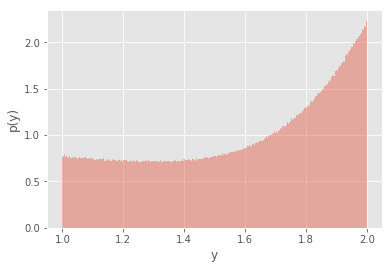

In [54]:
# set params
no_var = int(20e6)  # 20 million
no_burn = int(0.1 * 20e6)  # 10%

no_to_run = no_var + no_burn


# write densities
proposal = lambda z: 3/7. *  z*z
def p_yIx(y,x): return ((y*y-0.1*0.1) * (y-1.2) * (y-x) + 0.8)


# draw variables
x_i = sample_px(alpha=-1, no_samples=no_to_run)
u_var = uniform(size=no_to_run) 
q_var = sample_px(alpha=2, no_samples=no_to_run)  # re-sampling U


import timeit
start_time = timeit.default_timer()

# TODO: vectorize ... or numba
#from numba import jit
#@jit
def M_H(x_i,q_var,u_var,p_yIx, proposal, no_to_run):    
    
    current = 1.5    # y_{i-1}
    post = [current] # y_i, incl. burn points    
   
    for i in range(no_to_run):    
        x_ = x_i[i]        
        z_ = q_var[i]
    
        target_ratio = p_yIx(z_, x_) / p_yIx(current, x_)     
        proposal_ratio = proposal(current) / proposal(z_) 
    
        acceptance = min(1.0, target_ratio * proposal_ratio)
    
        if u_var[i] < acceptance: 
            current = z_
    
        post.append(current)
        
    return post


# result
y_i = M_H(x_i,q_var,u_var,p_yIx, proposal,no_to_run)[no_burn:]  # post[no_burn:]

print("seconds: {}" .format(timeit.default_timer() - start_time))


# histogram of p(y)
sns.distplot(y_i, norm_hist=True, kde=False, bins=1000, label="y")
plt.xlabel("y"); plt.ylabel("p(y)")


The density of p(y) seems to have the expected form (i.e. $p(y) = a \, y^2 - b \, y + c$)

### 3) 

Starting from first principles, we show below two ways to find the best 'alpha'. 


#### 1. Regression

The easiest method is to scale the $p(x)$ using the logarithm function and running a regression to find the slope (ie. alpha in the eq. below):

$\ln[p(x)] = \alpha \, \ln(x) + \text{const}$

Main problem with such approach is obviously that whilst the samples are iid, their log cannot be normal distributed (since samples are), in short the noise is not Gaussian. Other issues reported in the literature - such as failings in capturing the tail of the distribution - are not much relevant in our context.

To simplify, we create an histogram of the samples from p(x) with alpha equal to 10 and then run a regression (with real noisy data this has the effect to damp the noise).

In [50]:
# let's sample 2 million variables from p(x) with alpha = 10
alpha_to_sample = 10
samples_a10 = sample_px(alpha=alpha_to_sample, no_samples=no_rnd_samples, U_rnd=U)  # = np.sqrt((4 - 1) * U + 1) 

In [51]:
# bin the distributions 
no_bins_xfit = 200
bins_xfit = np.array([1.+i/no_bins_xfit for i in range(0,no_bins_xfit+1)])

hist, bin_edges = np.histogram(samples_a10, bins=bins_xfit, density=True) 

# get mid-points of bins (not really necessary in our idealised scenario), but it costs nothing...
mid_bins = bin_edges[:-1] + 1./no_bins_xfit*0.5

In [52]:
# reshape from (no_bins_xfit,) to (1, no_bins_xfit), apply log
log_hist = np.log( hist[:, np.newaxis] )
log_mid_bins = np.log( mid_bins[:, np.newaxis])

# fit ln[p(x)] = alpha * ln(x) + c
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(log_mid_bins, log_hist)

print("Alpha from regression fitting is {:.3f} vs. expected of {} ".format(float(lm.coef_), alpha_to_sample))
print("Out of curiosity the intercept is {:.2f}" .format(float(lm.intercept_)))

Alpha from regression fitting is 10.001 vs. expected of 10 
Out of curiosity the intercept is -5.23


With a simple regression we were able to get from the sampled variables an alpha of 10.001 vs. the expected 10. 

Not bad at all! 

#### 2. MLE

Let's calculate the MLE for p(x) when alpha is not -1.

$p(x|\alpha) = \prod_{i=1}^n \, \frac{\alpha + 1}{2^{a+1} - 1} \, x^{\alpha}$

and taking the logarithm we have:

$\ln[p(x|\alpha)] =
\ln \big[\prod_{i=1}^n \, \frac{\alpha + 1}{2^{\alpha+1} - 1} \, x^{\alpha} \big]= \sum_{i=1}^n \big[\ln(\alpha + 1) - \ln(2^{\alpha+1} - 1) + \alpha \; \ln(x)\big] =\\
\;\;\;\;\; = n \;  \ln(\alpha + 1) - n\; \ln(2^{\alpha+1} - 1) + \alpha \; \sum_{i=1}^n \ln(x)
$

now taking the derivative wrt $\alpha$ and setting it equal to zero:

$\frac{n}{\alpha+1} - \frac{n\, \ln(2) \, 2^{\alpha+1}}{2^{\alpha+1} - 1}  + \sum_{i=1}^n \ln(x)=0$

By numerically finding the root of the above eq. we get the MLE estimate of alpha.

Code below:

In [53]:
# numerical root finder
from scipy.optimize import brentq

n = no_rnd_samples
log_sum_x = np.sum(np.log(samples_a10))

f = lambda a: n / (a+1) - n * np.log(2) * 2**(a+1) / (2**(a+1) -1) + log_sum_x

root = brentq(f, 0, 20)


print("Alpha from MLE is {:.3f} vs. expected of {}. ".format(root, alpha_to_sample))


Alpha from MLE is 10.000 vs. expected of 10. 


Which works even faster (and I expect stabler for higher $\alpha$) vs. regression.
